# **Assignment 1 - Group 21**

# Introduction

This Jupyter notebook presents the key findings from our work on feature processing and model training. It follows the **ML Project Checklist**, incorporating each key point along with relevant code and outputs.

# Setup

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Imports and Functions

In [3]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier


def plot_corr_matrix(data):
    corr = data.corr()
    plt.figure(figsize=(18, 8))
    sns.heatmap(corr, annot=True,mask=np.triu(corr), cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix")
    plt.show() 


def plot_target_distribution(data, targets):

    counts = data[targets].sum()

    plt.figure(figsize=(7, 3))
    counts.plot(kind="bar", color="skyblue", edgecolor="black")

    plt.title("Num instances of targets")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.show()


def reduce_attribute(data, attribute_name, fraction):
    """Reduces the amount of instances of an attribute by a fraction"""
    # Extract attribute column
    atribute_column = data[data[attribute_name] == 1]

    # Remove 50 % of other fualts
    atribute_column_sampled = atribute_column.sample(frac=fraction, random_state=21)

    # Get all classes except other faults
    other_classes = data[data[attribute_name] == 0]

    # Stitch togeather
    data = pd.concat([other_classes, atribute_column_sampled])

    return data


def plot_learning_curves(model, X_train, X_test, y_train, y_test, step_size=1000, title="Learning Curves", min_data_length=50):
    train_errors, val_errors = [], []

    # Konverter y_train og y_test til 1D hvis de er one-hot encoded
    y_train = np.argmax(y_train, axis=1)  # Konverter one-hot til 1D labels
    y_test = np.argmax(y_test, axis=1)  # Konverter one-hot til 1D labels

    # Train and predict using train and test set for a range of data
    for m in range(min_data_length, len(X_train), step_size):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_test)

        train_errors.append(1 - accuracy_score(y_train[:m], y_train_predict))
        val_errors.append(1 - accuracy_score(y_test, y_val_predict))

    # Make sure the whole dataset is used and errors are appended
    model.fit(X_train, y_train)
    y_train_predict = model.predict(X_train)
    y_val_predict = model.predict(X_test)

    train_errors.append(1 - accuracy_score(y_train, y_train_predict))
    val_errors.append(1 - accuracy_score(y_test, y_val_predict))

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(train_errors, "r-+", linewidth=2, label="Train error")
    plt.plot(val_errors, "b-", linewidth=3, label="Validation error")
    plt.title(title)
    plt.xlabel("Training set size")
    plt.ylabel("Error (1 - Accuracy)")
    plt.legend()
    plt.grid(True)
    plt.show()


# To plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    y_true = np.argmax(y_true, axis=1) # convert to 1d labels
    y_pred = np.argmax(y_pred, axis=1) 
    cm = confusion_matrix(y_true, y_pred) # get confusion matrix
    
    # Plot
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Print score
def print_score(y_pred, y_test):
    """ Input: One-hot encoded predictions and test labels. """
    # Convert to 1d arrays
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    
    #Print classification report
    print(classification_report(y_test_labels, y_pred_labels, target_names=targets))


## **Framing the problem**
###  **Buisiness Objective**
The goal of this project is to automate and enhance fault classification in steel plate production, enabling efficient quality control without relying on manual inspection. Manual classification requires expertise, consistency, and skill, which can vary across workers. Accurate fault classification provides valuable insights for maintenance and repairs.

A well-designed ML solution will increase efficiency, reduce costs, and ensure more consistent classifications over time. The model will be integrated into the production line, continuously identifying faults in real time to support proactive maintenance.

### **Method and Performance**
The chosen method is supervised learning, utilizing real-world data on visual defects and fault classification. As we will see later, the class distribution is highly imbalanced, making overall accuracy an unsuitable metric. Simply predicting the majority class would yield a deceptively high accuracy.

Instead, we prioritize individual class performance, with a particular focus on the F1-score, as it balances precision and recall, providing a more meaningful assessment of model performance across all classes.

Since our dataset consists exclusively of faulty samples, our primary concern is not minimizing false negatives (which would be relevant if distinguishing between defective and non-defective items). Instead, we focus on accurately classifying the different types of faults, making recall particularly important for ensuring that all defect categories are well identified.

To meet the business objective, we assume a minimum required F1-score above 75% for most defect categories to ensure a reliable classification.

### **Assumptions**
We assume that the dataset is derived from manual classification of steel plate faults, which likely introduces noise and inconsistencies. The "Other_Faults" class likely contains a mix of defects that overlap with other categories. Including this class in training may introduce noise, leading the model to overfit incorrect patterns or become confused due to class overlap.

After extensive testing with different models and analyzing the confusion matrix, our assumption is confirmed. Thus, it is reasonable to exclude "Other_Faults" for now. A potential approach for integrating this class in the future is to use it as a fallback category when the model assigns low confidence scores across all other classes.


## **Collect and Explore The Data**
Data is collected from Kaggle: https://www.kaggle.com/competitions/playground-series-s4e3/overview. 

The dataset is synthetically generated based on a smaller real-world dataset of steel plate faults. The format is .csv, making it easy to read and manipulate using the pandas dataframe.

No further actions are necessary for collecting the data. 


In [4]:
import pandas as pd

CSV_FILENAME = "steel_plate.csv" 
CSV_FOLDER_NAME = "Datasets"
CSV_FILEPATH = os.path.join(CSV_FOLDER_NAME, CSV_FILENAME)

try:
    raw_data = pd.read_csv(CSV_FILEPATH)
except Exception as e:
    print(e)

pd.set_option('display.max_columns', None) # Print all collumns

raw_data.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


## Explanation of Targets and Features

### Explanation of Steel Plate Faults
The following are descriptions of the different steel plate faults:

- **Pastry**: Small patches or irregularities on the surface of the steel plate, typically caused by imperfections in the manufacturing process or handling during transport. These imperfections affect surface smoothness and appearance.

- **Z_Scratch**: Narrow scratches or marks running **parallel** to the rolling direction. Caused by handling, machining, or contact with abrasive materials during production or transportation.

- **K_Scratch**: Similar to Z-Scratches but run **perpendicular** to the rolling direction. Also caused by handling, machining, or abrasive material contact.

- **Stains**: Discolored or contaminated areas on the surface of the steel plate, often caused by rust, oil, grease, or other foreign substances during processing, storage, or handling.

- **Dirtiness**: Presence of dirt or particulate matter on the surface. This includes various types of debris or contaminants that accumulate during manufacturing, handling, or storage.

- **Bumps**: Raised or protruding areas on the surface, caused by irregularities in the manufacturing process, such as uneven rolling or cooling, or by physical damage during handling or transport.

- **Other_Faults**: A broader category encompassing surface imperfections, irregularities, or abnormalities that affect the quality or usability of the steel plate.

---

## Explanation of the Features

The dataset **Steel Plates Faults** contains **27 features** that describe each fault in detail. Below is an explanation of some key features:

### Location Features
- **X_Minimum**: Minimum x-coordinate of the fault.
- **X_Maximum**: Maximum x-coordinate of the fault.
- **Y_Minimum**: Minimum y-coordinate of the fault.
- **Y_Maximum**: Maximum y-coordinate of the fault.

### Size Features
- **Pixels_Areas**: Area of the fault in pixels.
- **X_Perimeter**: Perimeter along the x-axis of the fault.
- **Y_Perimeter**: Perimeter along the y-axis of the fault.

### Luminosity Features
- **Sum_of_Luminosity**: Sum of luminosity values in the fault area.
- **Minimum_of_Luminosity**: Minimum luminosity value in the fault area.
- **Maximum_of_Luminosity**: Maximum luminosity value in the fault area.

### Material and Index Features
- **TypeOfSteel_A300**: Type of steel (A300).
- **TypeOfSteel_A400**: Type of steel (A400).
- **Steel_Plate_Thickness**: Thickness of the steel plate.
- **Edges_Index, Empty_Index, Square_Index, Outside_X_Index, Edges_X_Index, Edges_Y_Index, Outside_Global_Index**: Various index values related to edges and geometry.

### Logarithmic Features
- **LogOfAreas**: Logarithm of the area of the fault.
- **Log_X_Index, Log_Y_Index**: Logarithmic indices related to X and Y coordinates.

### Statistical Features
- **Orientation_Index**: Index describing orientation.
- **Luminosity_Index**: Index related to luminosity.
- **SigmoidOfAreas**: Sigmoid function applied to areas.

In [5]:
# Drop ID collum
raw_data_drop_id = raw_data.drop(columns=["id"])

# Split into features and target
initial_targets = ["Pastry","Z_Scratch","K_Scatch","Stains","Dirtiness","Bumps","Other_Faults"]
initial_features = [col for col in raw_data_drop_id.columns if col not in initial_targets]

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19219 entries, 0 to 19218
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     19219 non-null  int64  
 1   X_Minimum              19219 non-null  int64  
 2   X_Maximum              19219 non-null  int64  
 3   Y_Minimum              19219 non-null  int64  
 4   Y_Maximum              19219 non-null  int64  
 5   Pixels_Areas           19219 non-null  int64  
 6   X_Perimeter            19219 non-null  int64  
 7   Y_Perimeter            19219 non-null  int64  
 8   Sum_of_Luminosity      19219 non-null  int64  
 9   Minimum_of_Luminosity  19219 non-null  int64  
 10  Maximum_of_Luminosity  19219 non-null  int64  
 11  Length_of_Conveyer     19219 non-null  int64  
 12  TypeOfSteel_A300       19219 non-null  int64  
 13  TypeOfSteel_A400       19219 non-null  int64  
 14  Steel_Plate_Thickness  19219 non-null  int64  
 15  Ed

In [7]:
# Look for missing data
missing_data = raw_data_drop_id.isna().sum().sum()
print(f"Amount of missing data: {missing_data}") 

Amount of missing data: 0


In [8]:
# Get more insight
raw_data_drop_id.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,19219.000000,19219.000000,1.921900e+04,1.921900e+04,19219.000000,19219.000000,19219.000000,1.921900e+04,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000
mean,709.854675,753.857641,1.849756e+06,1.846605e+06,1683.987616,95.654665,64.124096,1.918467e+05,84.808419,128.647380,1459.350747,0.402674,0.596337,76.213122,0.352939,0.409309,0.574520,0.030609,0.614749,0.831652,0.591899,2.473475,1.312667,1.389737,0.102742,-0.138382,0.571902,0.076279,0.059837,0.178573,0.029554,0.025235,0.247828,0.341225
std,531.544189,499.836603,1.903554e+06,1.896295e+06,3730.319865,177.821382,101.054178,4.420247e+05,28.800344,14.196976,145.568687,0.490449,0.490644,53.931960,0.318976,0.124143,0.259436,0.047302,0.222391,0.220966,0.482050,0.760575,0.467848,0.405549,0.487681,0.120344,0.332219,0.265450,0.237190,0.383005,0.169358,0.156844,0.431762,0.474133
min,0.000000,4.000000,6.712000e+03,6.724000e+03,6.000000,2.000000,1.000000,2.500000e+02,0.000000,39.000000,1227.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.008300,0.001500,0.014400,0.105000,0.000000,0.778200,0.301000,0.000000,-0.988400,-0.885000,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.000000,214.000000,6.574680e+05,6.575020e+05,89.000000,15.000000,14.000000,9.848000e+03,70.000000,124.000000,1358.000000,0.000000,0.000000,40.000000,0.058600,0.317500,0.375750,0.006600,0.451600,0.655200,0.000000,1.949400,1.000000,1.079200,-0.272700,-0.192500,0.253200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,777.000000,796.000000,1.398169e+06,1.398179e+06,168.000000,25.000000,23.000000,1.823800e+04,90.000000,127.000000,1364.000000,0.000000,1.000000,69.000000,0.238500,0.413500,0.545400,0.009500,0.636400,0.964300,1.000000,2.227900,1.146100,1.322200,0.111100,-0.142600,0.472900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1152.000000,1165.000000,2.368032e+06,2.362511e+06,653.000000,64.000000,61.000000,6.797800e+04,105.000000,135.000000,1652.000000,1.000000,1.000000,80.000000,0.656100,0.494600,0.818200,0.019100,0.785700,1.000000,1.000000,2.814900,1.431400,1.707600,0.529400,-0.084000,0.999400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,7553.000000,903.000000,1.159141e+07,196.000000,253.000000,1794.000000,1.000000,1.000000,300.000000,0.995200,0.927500,1.000000,0.665100,1.000000,1.000000,1.000000,4.554300,2.997300,4.033300,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


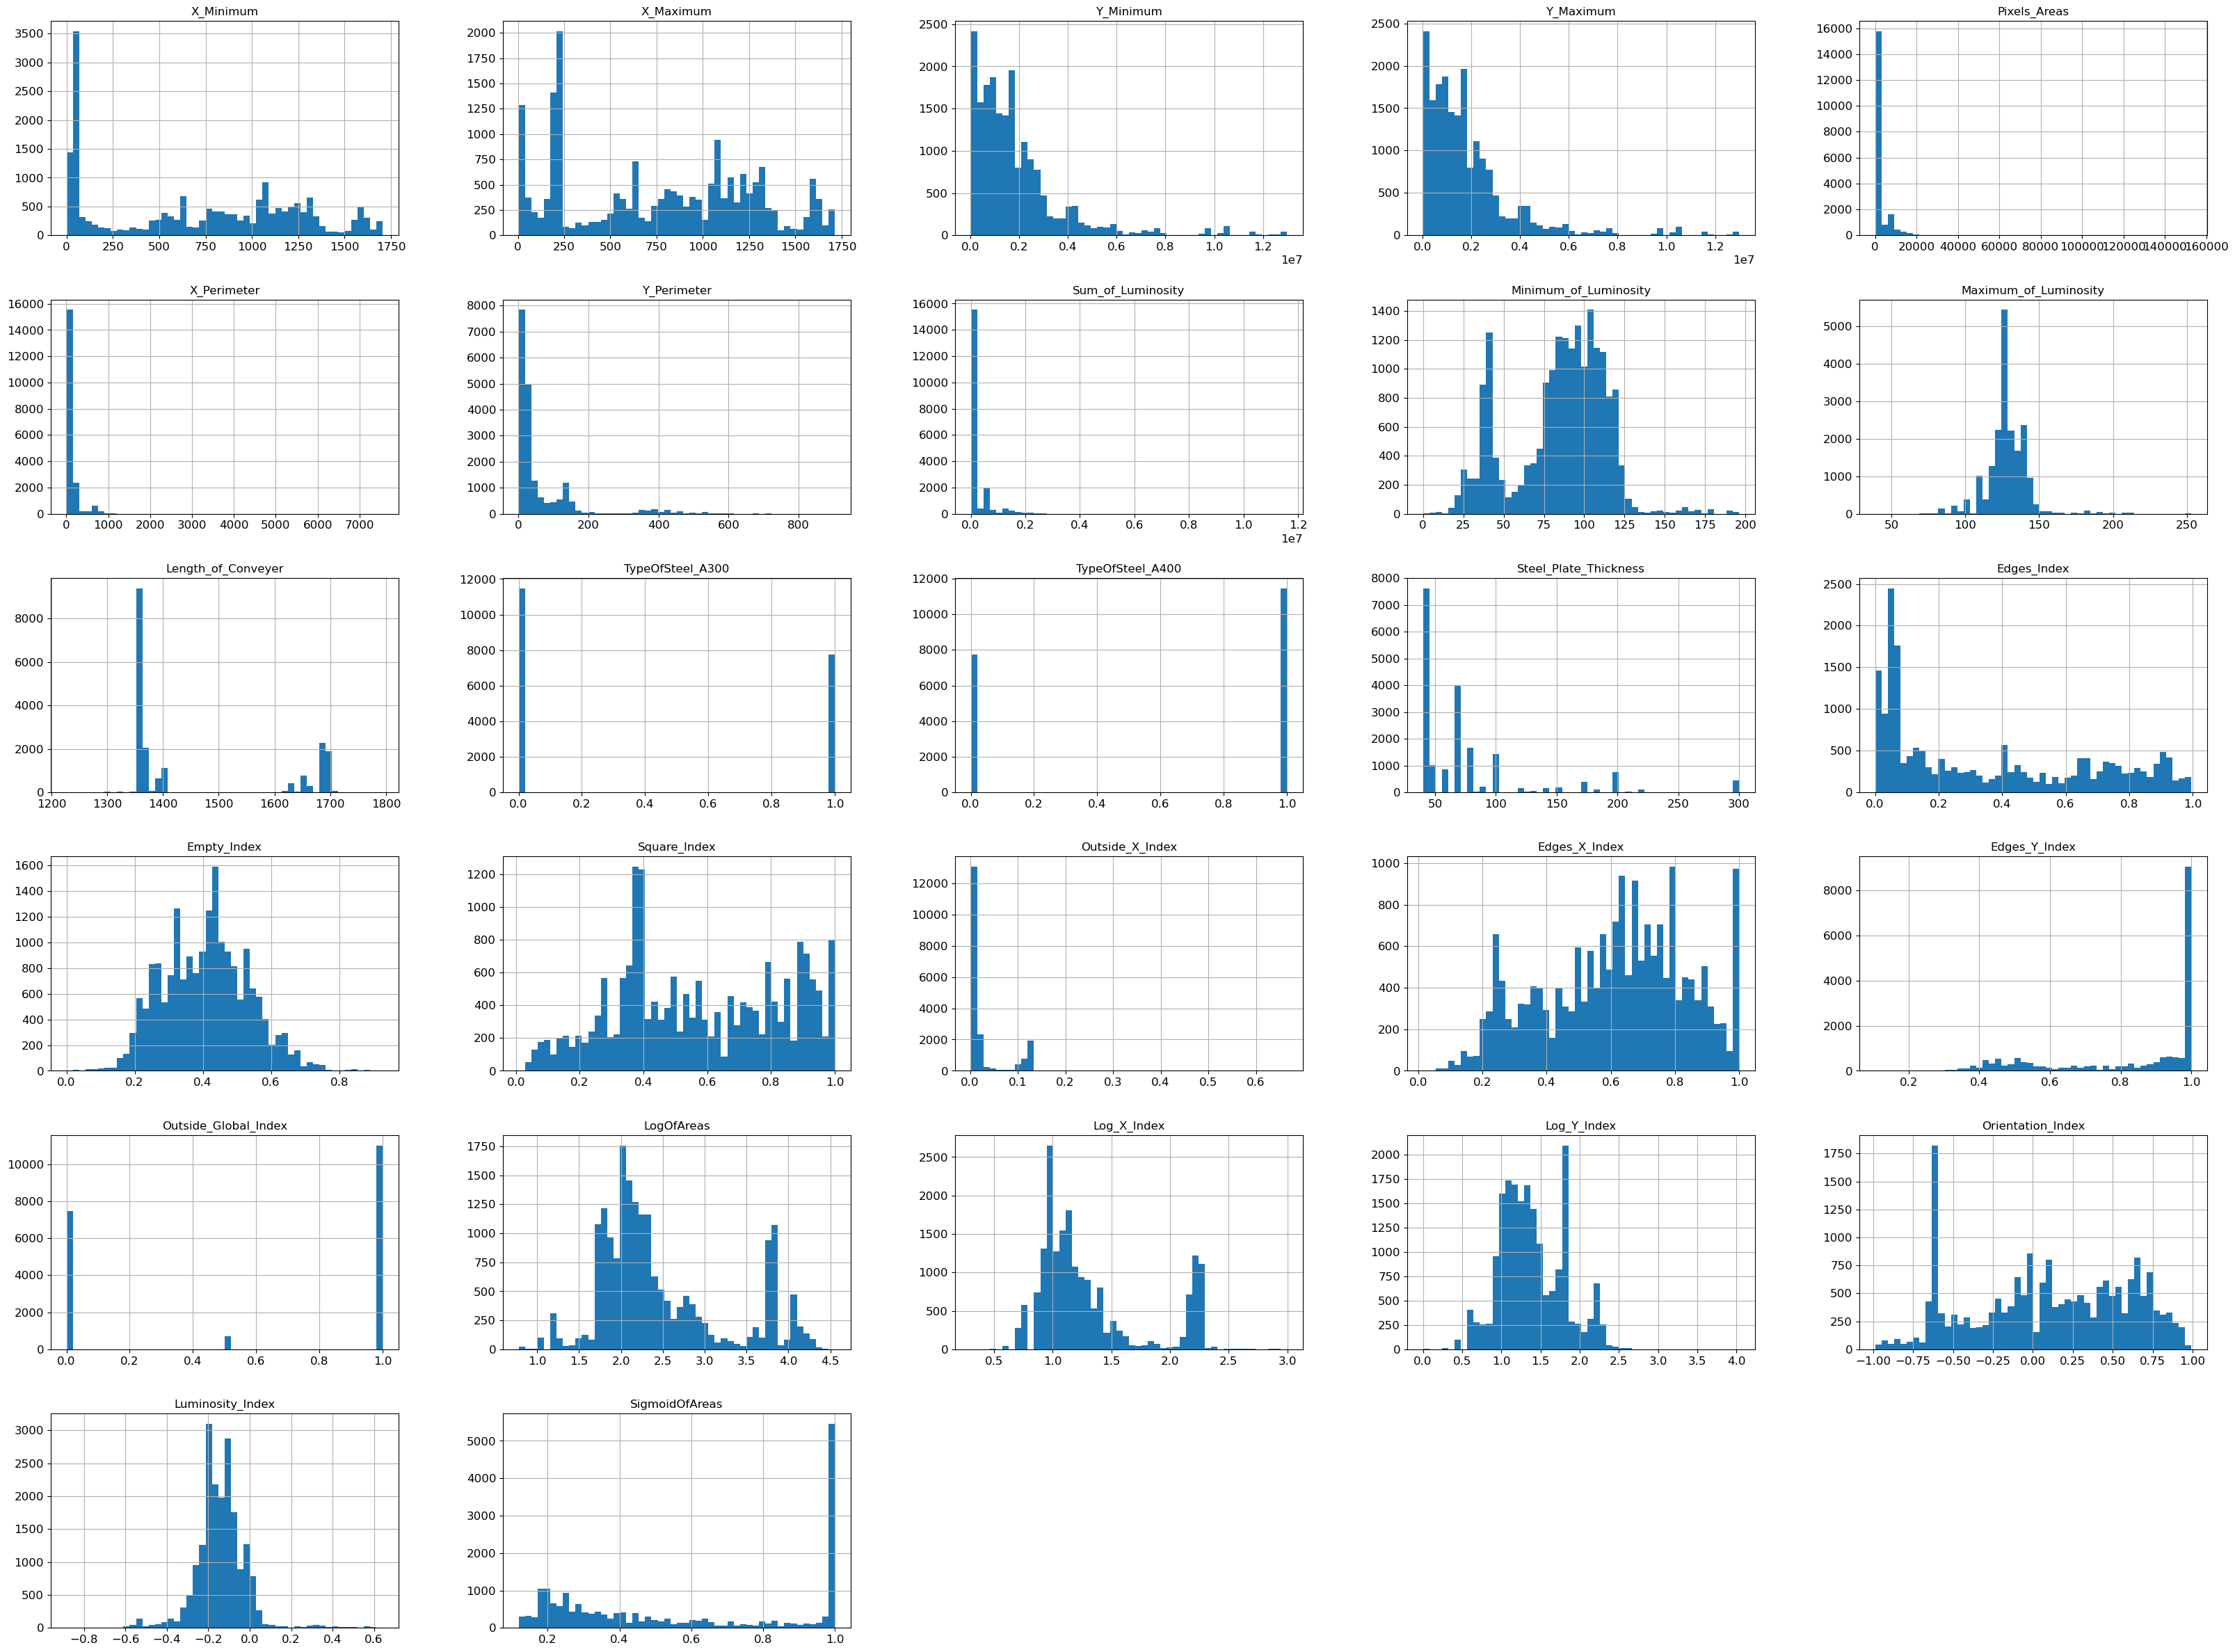

In [9]:
# Plot distribution of features
raw_data_drop_id[initial_features].hist(bins=50, figsize=(40,30))
plt.show()

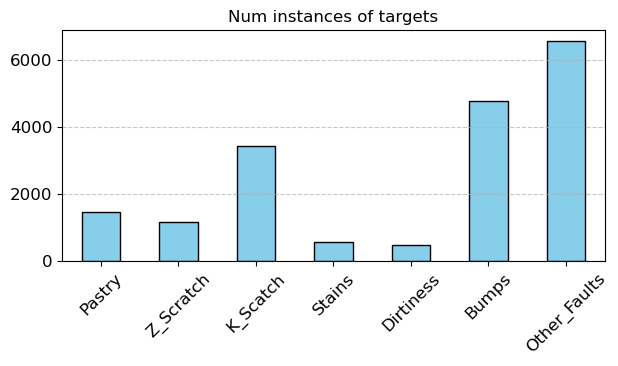

In [10]:
# Plot distribution of targets
plot_target_distribution(raw_data, initial_targets)

### Observations

* The dataset contains no missing data, so imputation is not required.

* As seen from ``.info()``, the dataset consists only of integer and float values.

* The last seven attributes represent the target classes. They are already one-hot encoded, so no further processing is needed.

* From ``.describe()``, we observe that some attributes have a wide range of values. For example, **Pixels_Areas** ranges from 6 to 152,655. We will ensure these are properly scaled before training.

* The histogram plot reveals that certain features contain outliers, with **Pixels_Areas** being a clear example. To handle outliers, we will use RobustScaler for these columns.

* Some attributes are most meaningful in their original scale, such as **Orientation_Index**, which describes the defect’s orientation. Other "index" values range from -1 to 1 or 0 to 1, which likely do not require scaling.

* The target distribution is imbalanced, which may cause the model to bias toward the majority class and impact generalization.

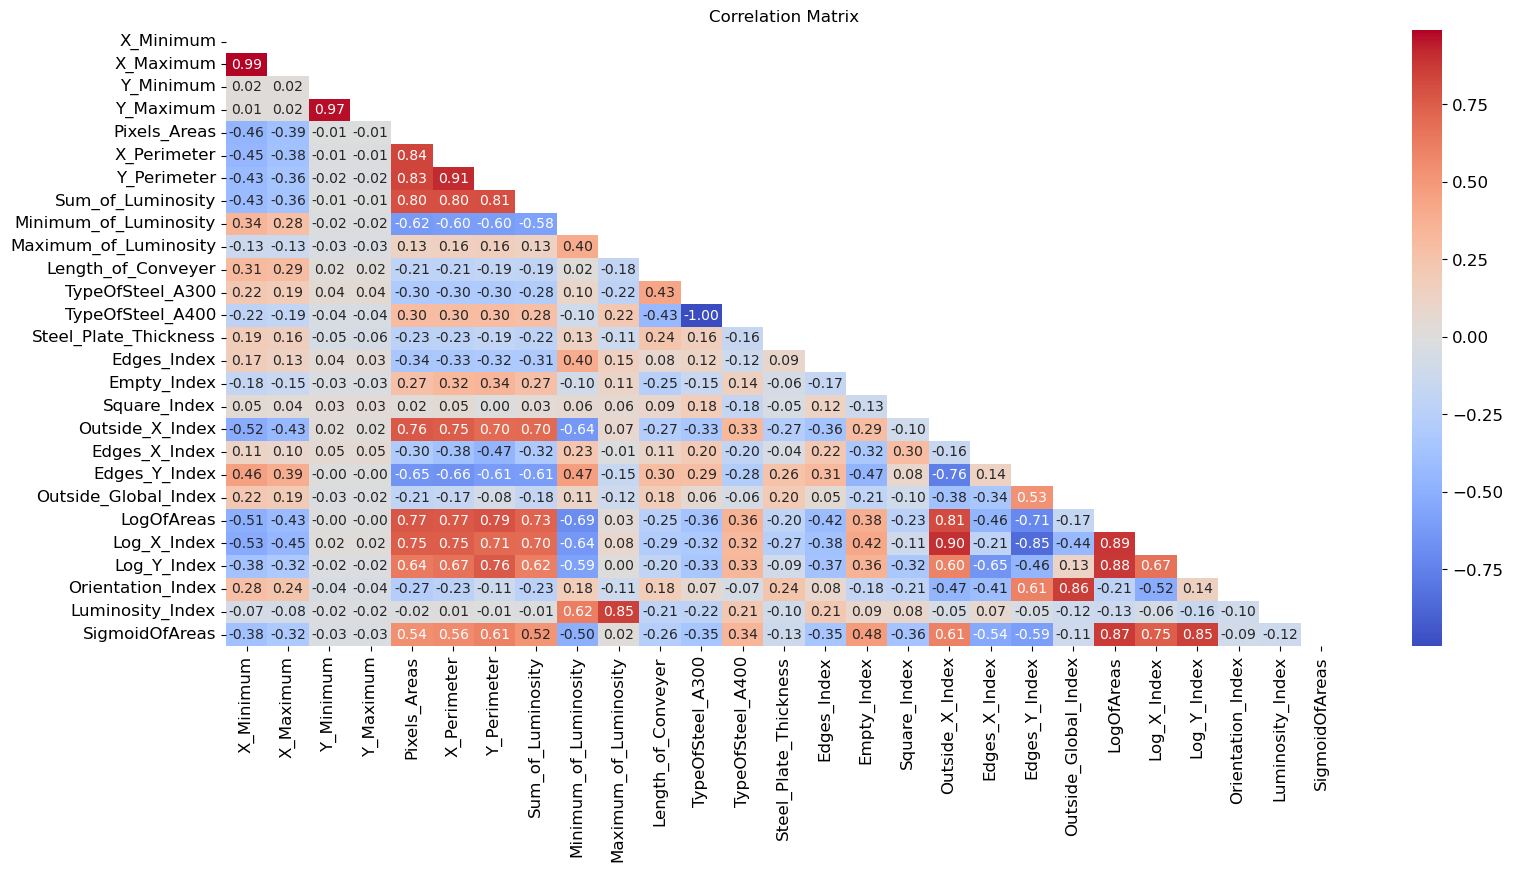

In [11]:
# Plot correlation matrix of features
plot_corr_matrix(raw_data_drop_id[initial_features])

### Correlated data

* Correlated attributes were removed to eliminate redundancy, reduce noise, and prevent overfitting.
For example, **TypeOfSteel** is binary (one value implies the other), so we only keep one of them (correlation = -1).
Additional attributes were excluded through experimentation, as their removal improved model performance.

* We also experimented with dimensionality reduction using PCA, but it resulted in worse performance.
Feature engineering proved to be the more effective approach.

# Feature selection

* By looking at the correlation matrix, as well as experimenting, we removed the following columns: 

    `['id', 'TypeOfSteel_A300', 'Y_Minimum', 'Sum_of_Luminosity', 
    'Edges_X_Index', 'Outside_Global_Index', 'SigmoidOfAreas', 
    'Luminosity_Index', 'X_Minimum', 'Log_X_Index']`

* New meaningful features were added, such as **Length** and **Total_Perimeter**. **Total_Perimeter** combines **Perimeter_X** and **Perimeter_Y**, which are highly correlated.

* A class ``FeatureModifier()`` was made to handle these modifications.

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureModifier(BaseEstimator, TransformerMixin):
    def __init__(self, add_length = False, 
                add_length_over_thickness = False,
                add_total_perimeter = False,
                drop_columns = True, 
                merge_targets=False, 
                drop_other_faults = False, 
                **merge_kwargs):
        
        self.add_length = add_length
        self.length_over_thickness = add_length_over_thickness
        self.add_total_perimeter = add_total_perimeter
        self.drop_columns = drop_columns
        self.merge_targets = merge_targets
        self.drop_other_faults = drop_other_faults
        self.merge_kwargs = merge_kwargs

        self.columns_to_drop = ['id', 'TypeOfSteel_A300', 'Y_Minimum', 'Sum_of_Luminosity', 
                                'Edges_X_Index', 'Outside_Global_Index', 'SigmoidOfAreas', 
                                'Luminosity_Index', 'X_Minimum', 'Log_X_Index']

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        X_transformed = X.copy()

        # ------- Add features ---------
        # Add meaningful attributes

        if self.length_over_thickness:
            X_transformed["Length_Over_Thickness"] = X["Length_of_Conveyer"] / X["Steel_Plate_Thickness"]


        if self.add_length:
            X_transformed["Length"] = np.sqrt( (X["X_Maximum"] - X["X_Minimum"])**2 + (X["Y_Maximum"] - X["Y_Minimum"])**2 )


        if self.add_total_perimeter:
            X_transformed["Total_Perimeter"] = X["X_Perimeter"] + X["Y_Perimeter"]
            X_transformed.drop(columns=["X_Perimeter", "Y_Perimeter"], inplace=True)


        # ------- Remove features ---------

        if self.merge_targets:
            for col, merge in self.merge_kwargs.items():
                if merge and col in X_transformed.columns:
                    X_transformed["Other_Faults"] += X_transformed[col]
                    X_transformed.drop(columns=[col], inplace=True)

        if self.drop_other_faults:
            # testing: remove other faults
            X_transformed = X_transformed[X_transformed["Other_Faults"] != 1]
            X_transformed.drop(columns=["Other_Faults"], inplace=True)

        # Drop specified columns
        if self.drop_columns:
            X_transformed.drop(columns = self.columns_to_drop, inplace=True)
        
        return X_transformed

In [12]:
# Get modified attributes
feature_modifier = FeatureModifier( 
    merge_targets=True, 
    drop_other_faults=True,

    # Extra features
    add_length_over_thickness = True,
    add_length = True,
    add_total_perimeter=True,

    # Set to true to exclude
    Pastry=False,
    Dirtiness=False, 
    Bumps=False
)

data_modified_attribs = feature_modifier.transform(raw_data)

# Update new target and features
targets = [col for col in data_modified_attribs.columns if col in initial_targets]
features = [col for col in data_modified_attribs.columns if col not in targets]

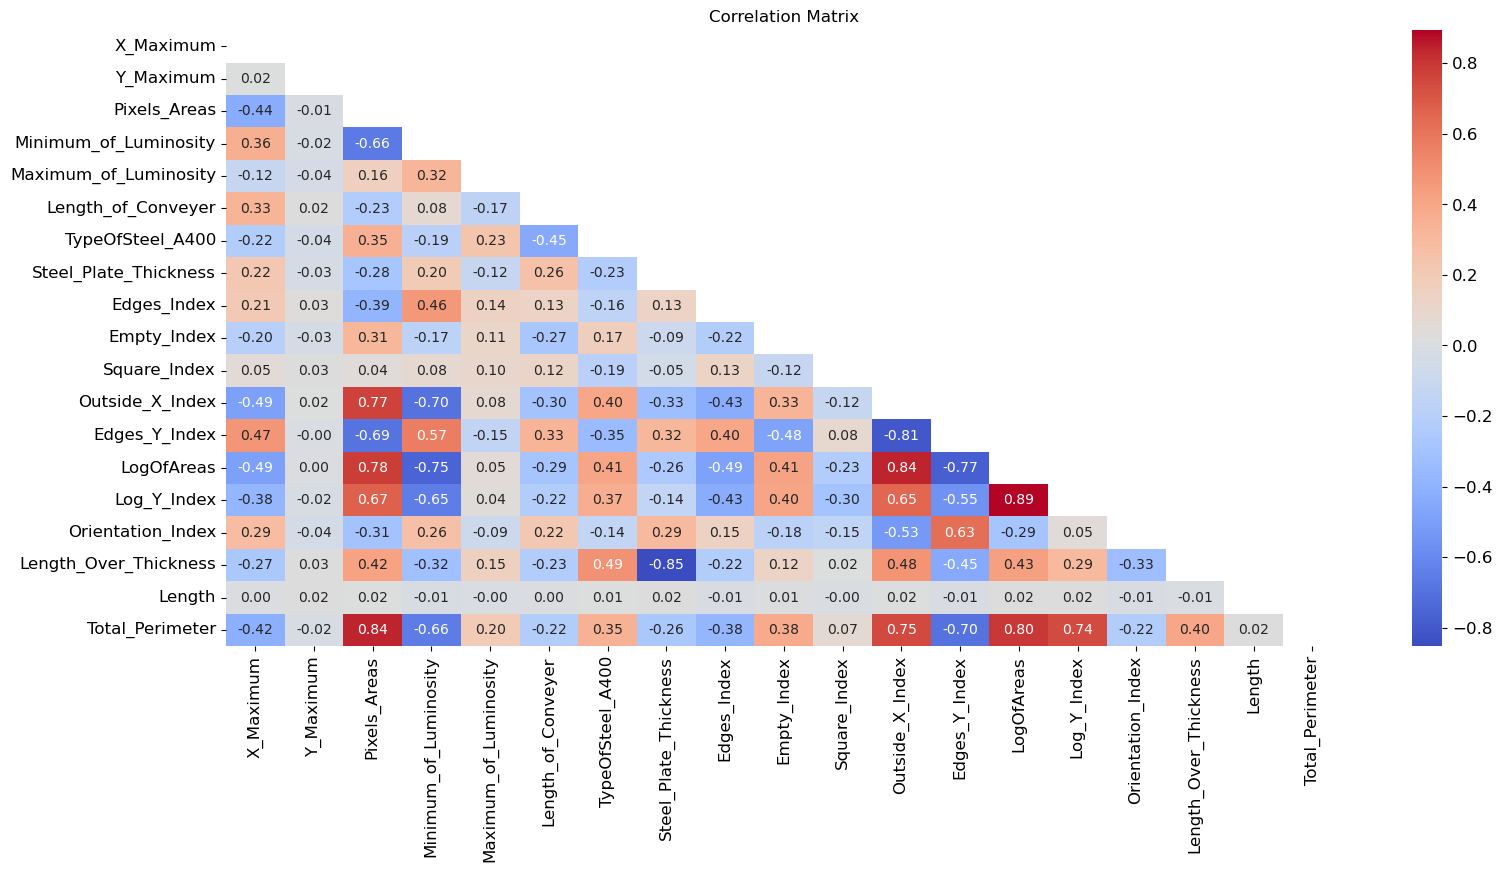

In [14]:
plot_corr_matrix(data_modified_attribs[features])

This looks more promising. There are still some features with highly corelated data. Better feature engineering could resolve this, but it will do for now.

# Split Into Test and Train

In [13]:
# Split into X and y
X = data_modified_attribs[features]
y = data_modified_attribs[targets]

# Split into a test set and a train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

print(f"Length of test set: {len(X_train)} \nLength of train set: {len(X_test)}")

Length of test set: 10128 
Length of train set: 2533


# Feature Scaling

In [14]:
# Define columns to exclude in scaling
exclude_scaling = ["Orientation_Index"]

# Define columns containing outliers
outliers = ['Total_Perimeter', 'Pixels_Areas', 'Outside_X_Index'] # Steel_Plate_Thickness

# Remaining features are scaled using standard scaler
standard = [col for col in features if col not in (outliers + exclude_scaling)]

# Init scalers
robust_scaler = RobustScaler()
standard_scaler = StandardScaler()

# Transform outliers using robust scaler
X_train[outliers] = robust_scaler.fit_transform(X_train[outliers])
X_test[outliers] = robust_scaler.fit_transform(X_test[outliers])

# Transform remaining features using standard scaler
X_train[standard] = standard_scaler.fit_transform(X_train[standard])
X_test[standard] = standard_scaler.fit_transform(X_test[standard])

# Convert to numpy arrays
X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values 

# **Training**

## Inspecting promising models

Lets do a k-fold cross-validation to inspect how well different models performs and generalizes to new unseen data.

In [30]:
# GB and SVC are binary classifiers and need to be packed in a one vs rest class
gb_clf = GradientBoostingClassifier(random_state=21)
svm = SVC(random_state=21)

models = {
    "rf": RandomForestClassifier(random_state=21),
    "svm": OneVsRestClassifier(svm),
    "gb": OneVsRestClassifier(gb_clf),
    "xgb": XGBClassifier(random_state=21)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # F1-score
    f1 = f1_score(y_test, y_pred, average="weighted")
    
    # Cross Validation med F1-score
    cv_scores = cross_val_score(model, np.vstack([X_train, X_test]), np.vstack([y_train, y_test]), cv=5, scoring="f1_weighted") # Include both train and test

    print(f"{name}: F1-score: {f1:.3f} \t Cross Val F1-score: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

rf: F1-score: 0.686 	 Cross Val F1-score: 0.722 ± 0.022
svm: F1-score: 0.684 	 Cross Val F1-score: 0.692 ± 0.010
gb: F1-score: 0.735 	 Cross Val F1-score: 0.750 ± 0.013
xgb: F1-score: 0.666 	 Cross Val F1-score: 0.735 ± 0.029


### Observations 
(numbers might differ slightly)
* Based on the updated results, the Gradient Boosting model outperforms the other models with a test F1-score of 0.735 and a cross-validation F1-score of 0.750 ± 0.013, indicating both strong performance and stability.

* The SVM model follows closely with a test F1-score of 0.684 and a cross-validation F1-score of 0.692 ± 0.010.

* The Random Forest model shows a test F1-score of 0.686 and a cross-validation F1-score of 0.722 ± 0.022, which suggests a slightly larger discrepancy between the test and cross-validation performance, potentially indicating some degree of overfitting.

* The XGBoost model achieves a test F1-score of 0.666 and a cross-validation score of 0.735 ± 0.029, indicating a noticeable drop in performance on the test set that might also point to some overfitting or differences in the test data distribution.

* Overall, Gradient Boosting appears to be the most robust and effective model based on these updated F1-score metrics.


# Fine tuning Gradient Boosting

In [ ]:
# Perform a randomized search for the best hyperparameters

gb_clf = GradientBoostingClassifier()

param_dist = {
    "estimator__n_estimators": [50, 75, 100], # "estimator__" is necessary when using One vs Rest
    "estimator__learning_rate": [0.1, 0.05, 0.01],
    "estimator__max_depth": [6, 8, 10],
    "estimator__min_samples_split": [50, 70, 90],
    "estimator__min_samples_leaf": [10, 20, 30],
    "estimator__subsample": [0.6, 0.7, 0.8]
}

# Wrap in One vs Rest
random_search_OvA = OneVsRestClassifier(gb_clf)

# Perform random search
random_search = RandomizedSearchCV(random_search_OvA, param_distributions=param_dist, n_iter=20, cv=5, scoring="f1_weighted", random_state=21)

# Fit the model
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)

Best parameters: {'estimator__subsample': 0.8, 'estimator__n_estimators': 100, 'estimator__min_samples_split': 70, 'estimator__min_samples_leaf': 20, 'estimator__max_depth': 6, 'estimator__learning_rate': 0.05}


* Best parameters: {'estimator__subsample': 0.8, 'estimator__n_estimators': 100, 'estimator__min_samples_split': 70, 'estimator__min_samples_leaf': 20, 'estimator__max_depth': 6, 'estimator__learning_rate': 0.05}

In [21]:
gb_best_params = { 
    'subsample': 0.8,
    'n_estimators': 150,
    'min_samples_split': 70,
    'min_samples_leaf': 20, 
    'max_depth': 6,
    'learning_rate': 0.05,
    'random_state': 21 
} 

# Init GradientBoostingClassifier
gradient_boosting_clf = GradientBoostingClassifier(**gb_best_params)

# Create one vs rest for it to work with multiple classes
gradient_boosting_clf_OvA = OneVsRestClassifier(gradient_boosting_clf)

# Training
gradient_boosting_clf_OvA.fit(X_train, y_train)

OneVsRestClassifier(estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                         max_depth=6,
                                                         min_samples_leaf=20,
                                                         min_samples_split=70,
                                                         n_estimators=150,
                                                         random_state=21,
                                                         subsample=0.8))

In [25]:
# Predict
y_pred_gb = gradient_boosting_clf_OvA.predict(X_test)

print_score(y_pred_gb, y_test)

              precision    recall  f1-score   support

      Pastry       0.42      0.56      0.48       468
   Z_Scratch       0.81      0.61      0.69       231
    K_Scatch       0.95      0.94      0.95       678
      Stains       0.86      0.95      0.91       110
   Dirtiness       0.54      0.08      0.13        93
       Bumps       0.75      0.73      0.74       953

    accuracy                           0.73      2533
   macro avg       0.72      0.65      0.65      2533
weighted avg       0.75      0.73      0.73      2533



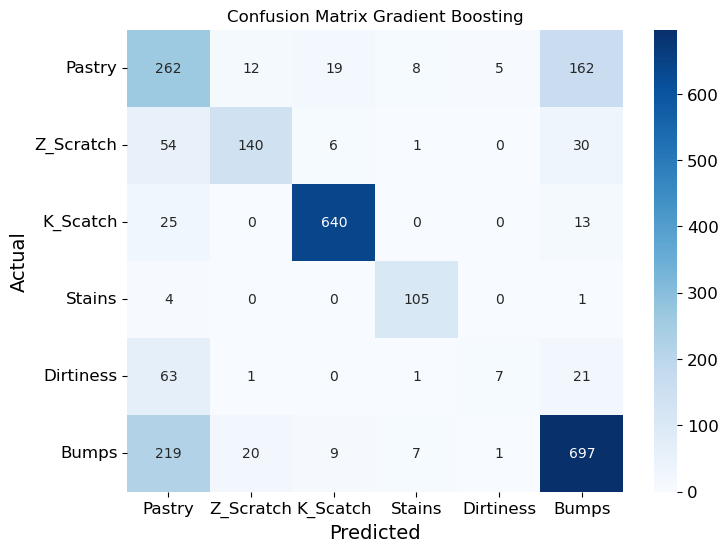

In [24]:
plot_confusion_matrix(y_test, y_pred_gb, targets, title="Confusion Matrix Gradient Boosting")

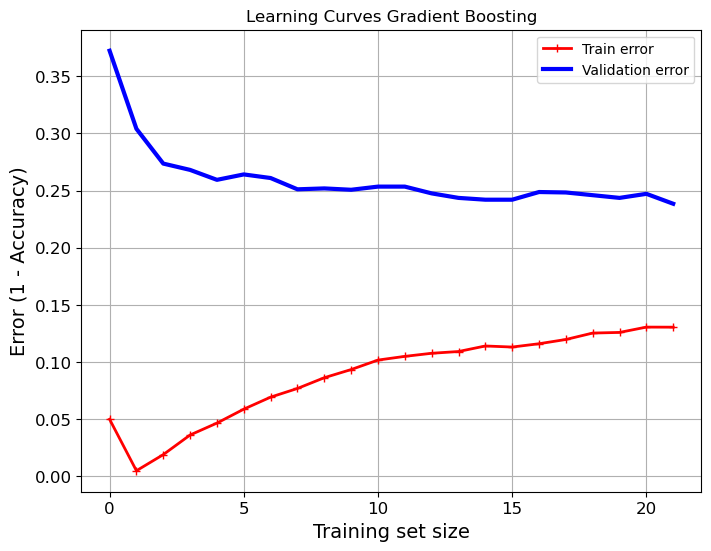

In [45]:
# Plot learning curve for the random forrest model
plot_learning_curves(gradient_boosting_clf_OvA, X_train, X_test, y_train, y_test, step_size=500, title="Learning Curves Gradient Boosting", min_data_length=100)

### Observations
* Gradient Boosting does a good job predicting **K_Scratch** and **Stains**. A F1-score of 0.74 for **Bumps** and 0.69 for **K_Scratch** is not great, but usable.
* We see from the learning curves that the model is overfitting, but the curves tend to come closer with more training data. 
* The model could likely be improved with further fine-tuning, but given our time constraints, this performance is acceptable.

# Fine tuning Random Forrest


In [ ]:
param_grid = {
    'n_estimators': [80, 100, 120],
    'max_depth': [20, 30, 40],
    'min_samples_split': [3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(class_weight='balanced', random_state=21)

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

* Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100}

In [49]:
rf_best_params = {
    'n_estimators': 200, 
    'max_features': 'sqrt', 
    'max_depth': 14, 
    'min_samples_split': 20, 
    'min_samples_leaf': 10, 
    'class_weight': 'balanced', 
    'random_state': 21 
} 

# Init random forrest
random_forrest_clf = RandomForestClassifier(**rf_best_params)

# Train the model
random_forrest_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=14,
                       min_samples_leaf=10, min_samples_split=20,
                       n_estimators=200, random_state=21)

In [50]:
y_pred_rf = random_forrest_clf.predict(X_test)

print_score(y_pred_rf, y_test)

              precision    recall  f1-score   support

      Pastry       0.34      0.85      0.48       468
   Z_Scratch       0.78      0.69      0.73       231
    K_Scatch       0.98      0.89      0.93       678
      Stains       0.83      0.95      0.89       110
   Dirtiness       0.59      0.24      0.34        93
       Bumps       0.88      0.35      0.50       953

    accuracy                           0.64      2533
   macro avg       0.73      0.66      0.65      2533
weighted avg       0.79      0.64      0.64      2533



### Inspecting the Confusion matricies

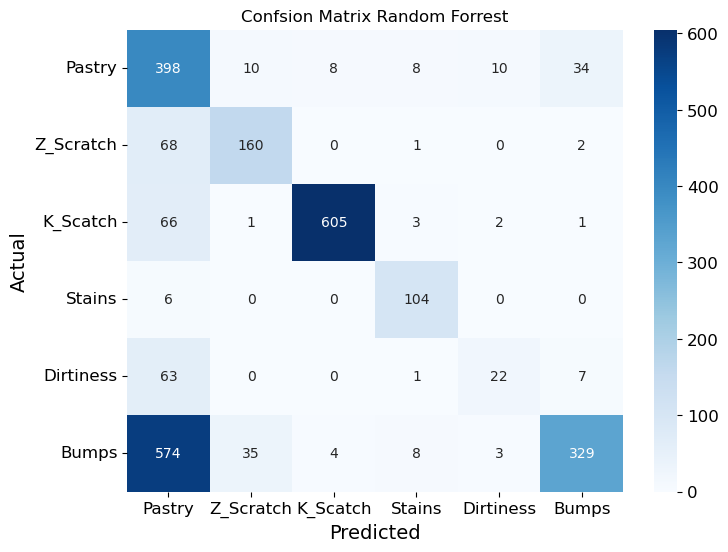

In [51]:
plot_confusion_matrix(y_test, y_pred_rf, targets, title="Confsion Matrix Random Forrest")

### Inspecting the Learning Curves

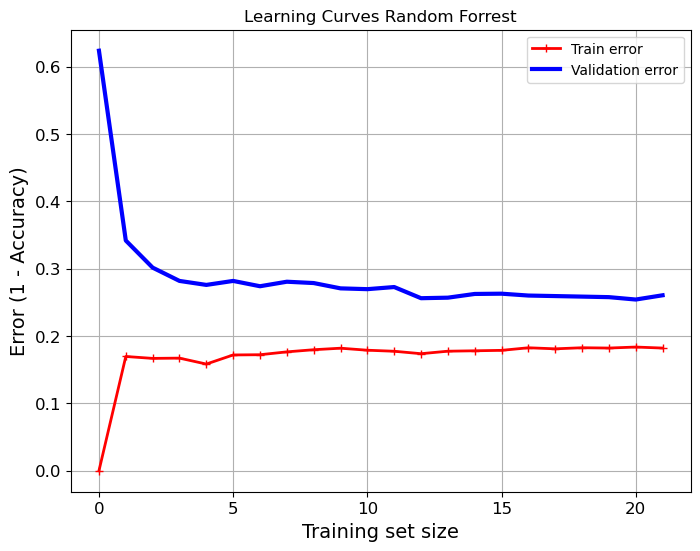

In [52]:
# Plot learning curve for the random forrest model
plot_learning_curves(random_forrest_clf, X_train, X_test, y_train, y_test, step_size=500, title="Learning Curves Random Forrest", min_data_length=1)

### Observations
* Just like Gradient Boosting, this model also confuses **Pastry** with **Bumps**. **Dirtiness** is way off and is confused with being **Pastery**. 
* Random Forrest manages to classify **Z_Sctratch**, **K_Sctratch** and **Stains** relatively well, but performs overall worse than Gradient Boosting.
* By plotting the learning curves (predictions on test data vs train data), we see a clear gap between train error and validation error, indicating an **overfitted** model. This is an issue that we struggle to eliminate, and it would be our key focus if we were to improve these models in the future. We see that the validation error decreases more rapidly compared to Gradient Boosting. More data would likely result in a less overfitted model.

# Fine tuning SVM

Different combinations of C and gamma were tuned manually to find a well performing model. 
* High C: The model tries to classify all training points correctly, allowing for less margin but fewer misclassifications. This can lead to overfitting.
* Low C: The model allows some misclassifications to increase the margin, leading to better generalization but potentially more training errors.
* High gamma: The model focuses more on individual training points, making the decision boundary more complex and wavy, which can lead to overfitting.
* Low gamma: The model considers points further away, leading to smoother decision boundaries and better generalization.

In [66]:
svm_clf = SVC(C=0.8, kernel='rbf', gamma=0.08, random_state=21)

svm_clf_OvA = OneVsRestClassifier(svm_clf)

svm_clf_OvA.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(C=0.8, gamma=0.08, random_state=21))

In [67]:
y_pred_SVM = svm_clf_OvA.predict(X_test)

print_score(y_pred_SVM, y_test)

              precision    recall  f1-score   support

      Pastry       0.40      0.53      0.46       468
   Z_Scratch       0.76      0.48      0.59       231
    K_Scatch       0.97      0.91      0.94       678
      Stains       0.91      0.90      0.90       110
   Dirtiness       0.86      0.13      0.22        93
       Bumps       0.71      0.76      0.74       953

    accuracy                           0.71      2533
   macro avg       0.77      0.62      0.64      2533
weighted avg       0.74      0.71      0.71      2533



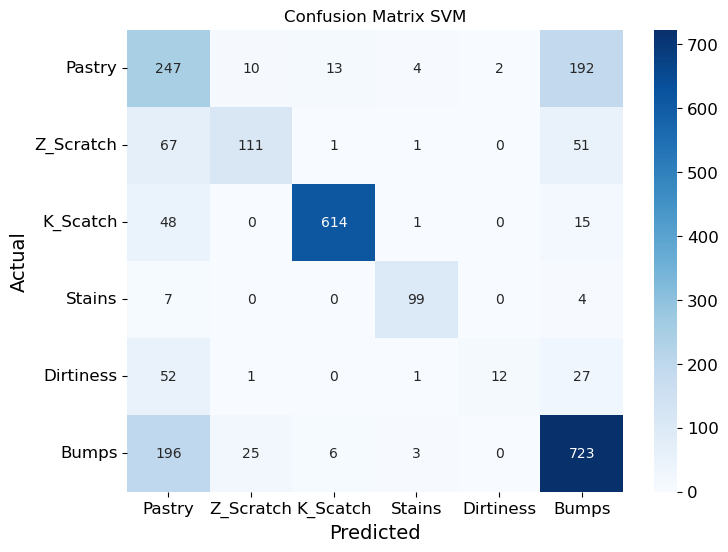

In [62]:
plot_confusion_matrix(y_test, y_pred_SVM, targets, title="Confusion Matrix SVM")

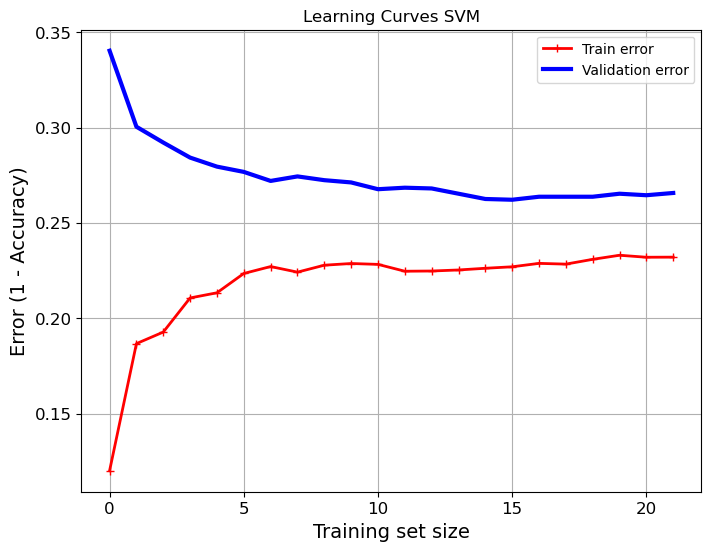

In [63]:
# Plot learning curves
plot_learning_curves(svm_clf_OvA, X_train, X_test, y_train, y_test, step_size=500, title="Learning Curves SVM", min_data_length=100)

# Observations

From the initial tests of all the models, SVM showed great potential. This was expected due to SVM's ability to handle complex small to medium datasets, which accurately describes the steel plate defect detection dataset we were working with. 

Different kernels were later tested with SVM: linear, polynomial, and Gaussian Radial Basis Function (RBF). The results showed that the linear kernel was not suitable for the task, but both the polynomial and RBF kernels showed great promise. However, polynomial kernels with degrees higher than 3 led to overfitting. The final result of the SVM testing indicated that SVM with RBF was the best choice, as the structure of the data was difficult to capture with a polynomial kernel.

We observe that the model is overfitting similarly to the other models. Attempts to reduce overfitting have led to a decline in overall performance, so we consider the current hyperparameters acceptable for now.

# Stacked Model
Lastly, we combine all three models into a stacked model using logistic regression as the last layer.

In [68]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression


svm_clf = SVC(C=1, kernel='rbf', gamma=0.3, random_state=21)
gradient_boosting_clf = GradientBoostingClassifier(**gb_best_params)

base_models = [
    ('rf', RandomForestClassifier(**rf_best_params)),
    ('gb', OneVsRestClassifier(gradient_boosting_clf)),
    ('svm', OneVsRestClassifier(svm_clf)),
]

# Define the final model
final_estimator = LogisticRegression()

# Define the stacking ensemble
stacked_model = MultiOutputClassifier(StackingClassifier(estimators=base_models, final_estimator=final_estimator, cv=5))

TRAIN_MODEL = True
if TRAIN_MODEL:
    # Fit the model on the training data
    stacked_model.fit(X_train, y_train)

In [69]:
y_pred_stacked_model = stacked_model.predict(X_test)

print_score(y_pred_stacked_model, y_test)

              precision    recall  f1-score   support

      Pastry       0.39      0.59      0.47       468
   Z_Scratch       0.86      0.44      0.58       231
    K_Scatch       0.96      0.94      0.95       678
      Stains       0.92      0.94      0.93       110
   Dirtiness       0.75      0.06      0.12        93
       Bumps       0.75      0.74      0.74       953

    accuracy                           0.72      2533
   macro avg       0.77      0.62      0.63      2533
weighted avg       0.76      0.72      0.72      2533



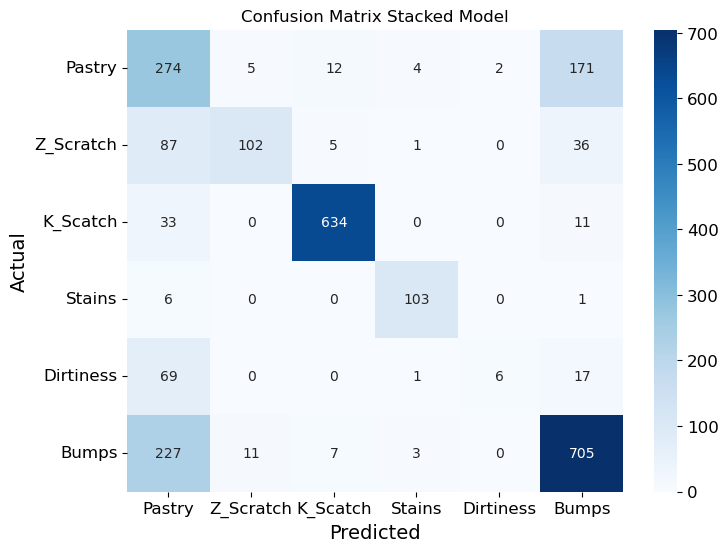

In [70]:
plot_confusion_matrix(y_test, y_pred_stacked_model, targets, title="Confusion Matrix Stacked Model")

The stacked model does not seem to improve performance.

# Conclusion and Key Findings

Overall, the Gradient Boosting Classifier performed best and is capable of predicting **K_Scratch**, **Stains** and **Bumps** within the F1-margin of 75 %. 

The persistent overfitting across all models and the very poor F1 scores for some classes can be attributed to several factors:
* An imbalanced dataset may result in insufficient representation of certain classes, leading the models to focus on the majority classes. 
* High levels of noise or inconsistent annotations in the data can cause the models to overfit on irrelevant patterns rather than learning robust features. 
* The issue may also stem from insufficient or non-informative features, which complicates the classification of similar classes in a 6-class problem. 

In summary, a combination of data quality issues, imbalanced class distribution, and model complexity is likely driving the observed overfitting and low F1 scores.

The next stem would be to address data quality and class imbalance. Potential improvements include:
* Collecting more diverse and representative data could significantly enhance the model’s ability to generalize and reduce overfitting.
* Better feature engineering.  
* Experimenting with different model architectures. 
* Resampling techniques (oversampling minority classes or undersampling majority classes).